In [ ]:
import os, math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Load data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# find data files
dir = "./drive/MyDrive/data"
all_files_name = os.listdir(dir)
data_files_name = [i for i in all_files_name if "hourly.csv" in i]
df_list = [pd.read_csv(dir+"/"+file_name,index_col='Datetime') for file_name in data_files_name]
print(f"{len(df_list)} files loaded.")

12 files loaded.


In [ ]:
# print summary of the power consumption
sample = [i.describe() for i in df_list]
pd.concat(sample, axis = 1)


,AEP_MW,DAYTON_MW,DEOK_MW,COMED_MW,EKPC_MW,FE_MW,DOM_MW,DUQ_MW,PJMW_MW,NI_MW,PJM_Load_MW,PJME_MW
count,121273.000000,121275.000000,57739.000000,66497.000000,45334.000000,62874.000000,116189.000000,119068.000000,143206.000000,58450.000000,32896.000000,145366.000000
mean,15499.513717,2037.851140,3105.096486,11420.152112,1464.218423,7792.159064,10949.203625,1658.820296,5602.375089,11701.682943,29766.427408,32080.222831
std,2591.399065,393.403153,599.859026,2304.139517,378.868404,1331.268006,2413.946569,301.740640,979.142872,2371.498701,5849.769954,6464.012166
min,9581.000000,982.000000,907.000000,7237.000000,514.000000,0.000000,1253.000000,1014.000000,487.000000,7003.000000,17461.000000,14544.000000
25%,13630.000000,1749.000000,2687.000000,9780.000000,1185.000000,6807.000000,9322.000000,1444.000000,4907.000000,9954.000000,25473.000000,27573.000000
50%,15310.000000,2009.000000,3013.000000,11152.000000,1386.000000,7700.000000,10501.000000,1630.000000,5530.000000,11521.000000,29655.000000,31421.000000
75%,17200.000000,2279.000000,3449.000000,12510.000000,1699.000000,8556.000000,12378.000000,1819.000000,6252.000000,12896.750000,33073.250000,35650.000000
max,25695.000000,3746.000000,5445.000000,23753.000000,3490.000000,14032.000000,21651.000000,3054.000000,9594.000000,23631.000000,54030.000000,62009.000000


In [ ]:
# get PJME consumption
df = df_list[-1]
df['date'] = [i[0:10] for i in df.index]
df_date = df.groupby(['date']).mean()
print(df_date)

                 PJME_MW
date                    
2002-01-01  31080.739130
2002-01-02  34261.541667
2002-01-03  34511.875000
2002-01-04  33715.458333
2002-01-05  30405.125000
...                  ...
2018-07-30  32957.416667
2018-07-31  34539.083333
2018-08-01  39230.791667
2018-08-02  39593.041667
2018-08-03  35486.000000

[6059 rows x 1 columns]


In [ ]:
# We only want the last 6 years 
# The data I can add to it, 
df_date = df_date[df_date.index >= "2012-01-01"] #
df_train, df_test = df_date[df_date.index < "2018-01-01"].values, \
                    df_date[df_date.index >= "2018-01-01"].values
print(f"train shape: {df_train.size} test shape: {df_test.size}")

train shape: 2192 test shape: 215


In [ ]:
df_date.head()

,PJME_MW
date,
2012-01-01,26920.916667
2012-01-02,30463.166667
2012-01-03,36219.208333
2012-01-04,39069.166667
2012-01-05,35579.583333


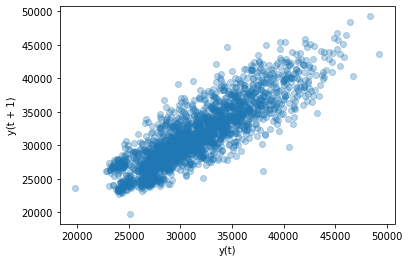

In [ ]:
# autocorrelation check
from pandas.plotting import lag_plot
lag_plot(df_date[df_date.index < "2018-01-01"], alpha=0.3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(df_train)
df_train = scaler.transform(df_train)
df_test = scaler.transform(df_test)

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
n_input = 12
n_features = 1
generated_batches = TimeseriesGenerator(df_train, df_train, length=n_input, batch_size=1)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss="mse")

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 51,001
Trainable params: 51,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generated_batches,epochs=100)

Epoch 1/100
2180/2180 [==============================] - 17s 7ms/step - loss: 0.0101
Epoch 2/100
2180/2180 [==============================] - 15s 7ms/step - loss: 0.0065
Epoch 3/100
2180/2180 [==============================] - 16s 7ms/step - loss: 0.0061
Epoch 4/100
2180/2180 [==============================] - 14s 7ms/step - loss: 0.0061
Epoch 5/100
2180/2180 [==============================] - 15s 7ms/step - loss: 0.0060
Epoch 6/100
2180/2180 [==============================] - 15s 7ms/step - loss: 0.0059
Epoch 7/100
2180/2180 [==============================] - 14s 7ms/step - loss: 0.0057
Epoch 8/100
2180/2180 [==============================] - 15s 7ms/step - loss: 0.0056
Epoch 9/100
2180/2180 [==============================] - 16s 7ms/step - loss: 0.0057
Epoch 10/100
2180/2180 [==============================] - 14s 7ms/step - loss: 0.0055
Epoch 11/100
2180/2180 [==============================] - 15s 7ms/step - loss: 0.0055
Epoch 12/100
2180/2180 [==============================] - 15s 7

In [ ]:
generated_batches_test = TimeseriesGenerator(df_test, df_test, length=n_input, batch_size=1)

In [ ]:
model.evaluate(generated_batches_test)

203/203 [==============================] - 1s 3ms/step - loss: 0.0067


0.006744735408574343

In [ ]:
testPredict = model.predict(generated_batches_test)

203/203 [==============================] - 0s 2ms/step


In [ ]:
actual_values = scaler.inverse_transform(testPredict)
df_test = scaler.inverse_transform(df_test)

In [ ]:
matched_df_test = df_test[12:]

Text(0, 0.5, 'Electricity Consumption (MW)')

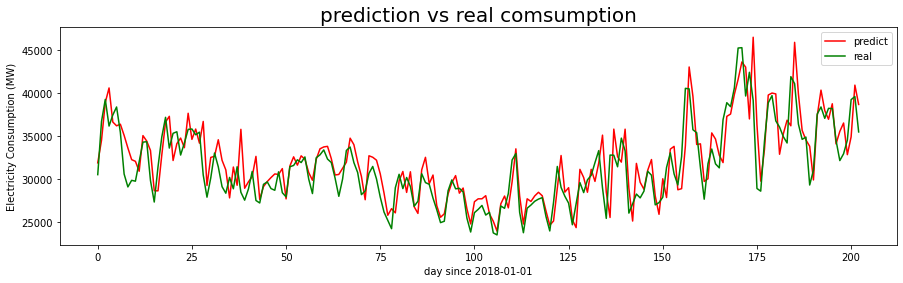

In [ ]:
# plot picture on test set.
fig, ax = plt.subplots(1,1,figsize=(15,4))
ax.plot(range(len(matched_df_test)), actual_values, 'red')
ax.plot(range(len(matched_df_test)), matched_df_test, 'green')
ax.legend(['predict','real'])
ax.set_title('prediction vs real comsumption',fontsize=20)
ax.set_xlabel('day since 2018-01-01')
ax.set_ylabel('Electricity Consumption (MW)')